# Law, Order, and Algorithms

## Estimating San Francisco surveillance camera density

In [43]:
# uncomment this line if have problems loading the libraries 
# install.packages(c("sf", "ggmap"))
library(tidyverse)
library(sf)
library(ggmap) # shouldn't need to add API key as I pre-saved the ggmap

theme_set(theme_bw(base_size = 14))
# suppress warnings
options(warn = -1, message=-1)

precision
<dbl>
0.4255319


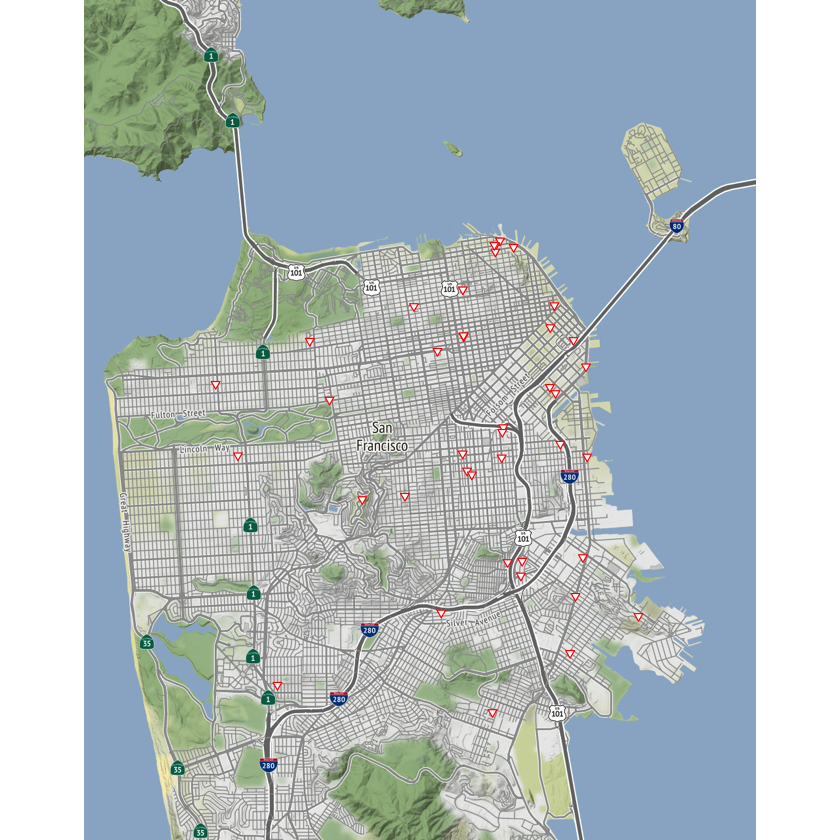

In [10]:

# Load data
load(file = "../data/surveillance_sf.RData")
# cameras_sf: (row per image, only allow one detection per image)
# - panoid = uid of image 
# - lat-lon = coordinates of image
# - period = year of image
# - detected, verified
# census_sf (row per census block group)
# - GEOID, NAME = uid of census block group
# - total_pop = total population of CBG
# - total_white = total non-Hispanic white population of CBG
# - geometry = multipolygon shape of census block group
# ggmap_sf
# - saved ggmap of San Francisco
# cameras_all (row per image, only allow one detection per image)
# - pre-cleaned file, variables should be self-explanatory

# Constants
recall <- 0.67
road_length_m <- 3108000 
avg_image_length_m <- 24.140665298930312

# 1. Compute precision
cameras_sf %>%
  summarize(precision = sum(verified) / sum(detected))

# 2. Estimate camera detections and density
n_images <- nrow(cameras_sf)
n_verified <- sum(cameras_sf$verified)
perc_road_covered <- avg_image_length_m * n_images / (2 * road_length_m)

est_cameras <- n_verified * (1 / recall) * (1 / perc_road_covered)
est_cameras_per_km <- est_cameras * 1000 / road_length_m

# 3. Plot detections on map
ggmap(ggmap_sf, extent = "device") +
  geom_point(data = cameras_sf %>% 
               filter(verified),
             aes(x = lon, y = lat),
             position = "jitter", 
             shape = 25, fill = "white", color = "red",
             alpha = 1, size = 1.5) +
  theme(axis.text = element_blank(), 
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank())

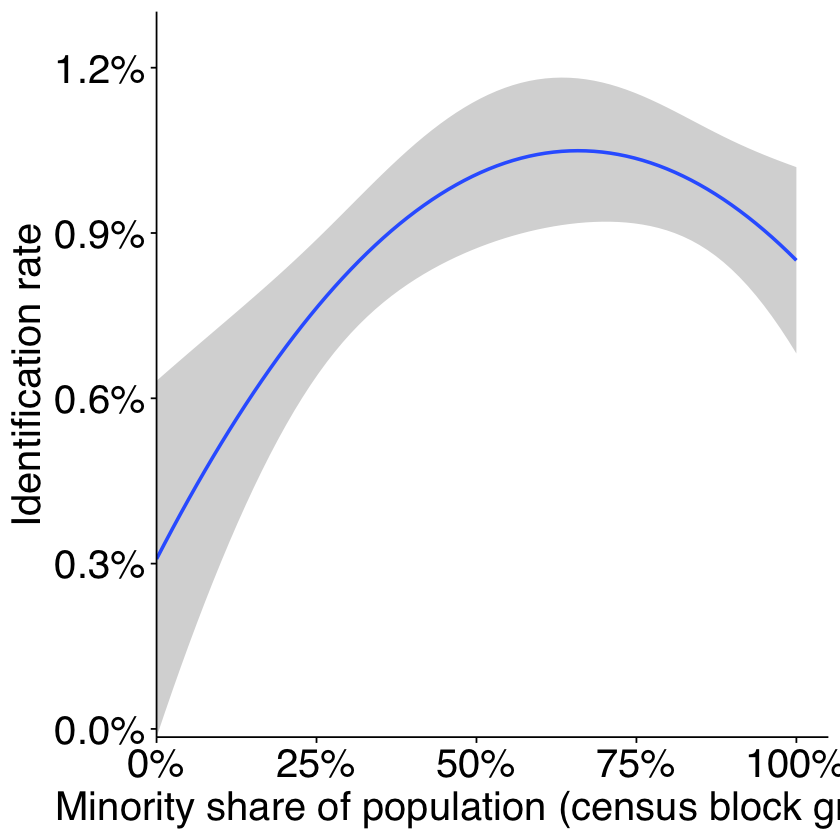

In [11]:
# 4: Plot detection rate against minority share for all cities
cameras_all %>%
  ggplot(aes(x = percentage_minority, y = verified)) +
  #geom_hline(yintercept = avg_detection_rate, linetype = "dashed", color = "gray") + # avg detection rate
  geom_smooth(method = "lm", 
              formula = y ~ poly(x, degree = 2),
              se = T) +
  scale_x_continuous(
    name = "Minority share of population (census block group)", 
    #breaks = seq(0, 1, 0.1),
    expand = expansion(mult = c(0, 0.05)),
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_y_continuous(
    name = "Identification rate",  
    breaks = seq(0, 0.012, 0.003),
    expand = expansion(mult = c(0, 0.1)),
    labels = scales::percent_format(accuracy = 0.1)
  ) +
  theme(
    panel.grid = element_blank(),
    panel.border = element_blank(),
    axis.text = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.title = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.line = element_line(size = 0.5, color = "black"),
    axis.ticks.x = element_line(size = 0.5, color = "black"),
    axis.ticks.y = element_line(size = 0.5, color = "black")
  ) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



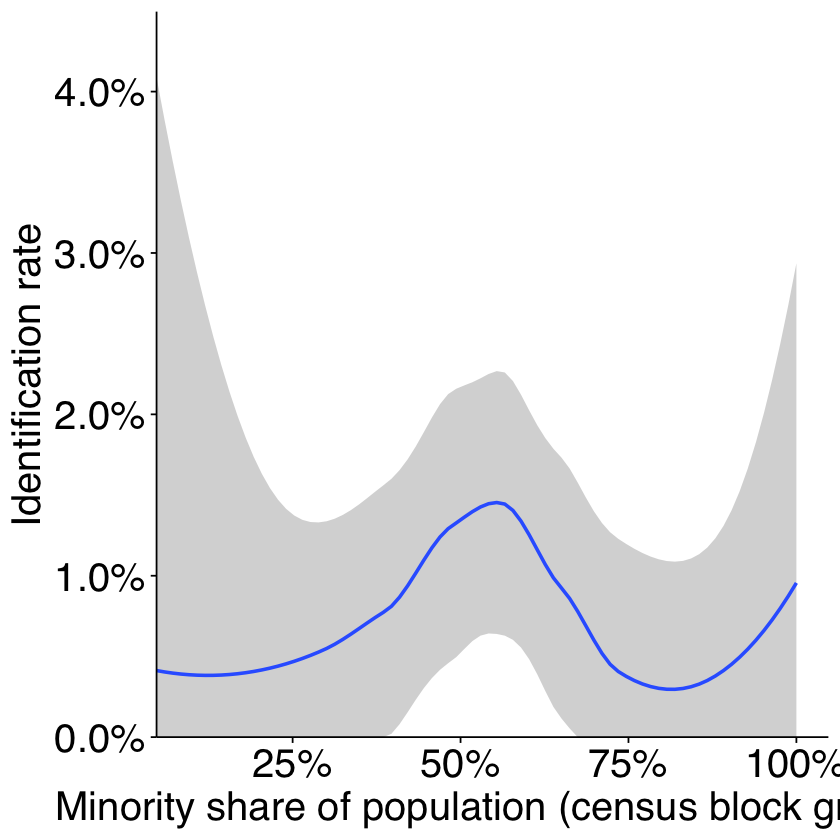

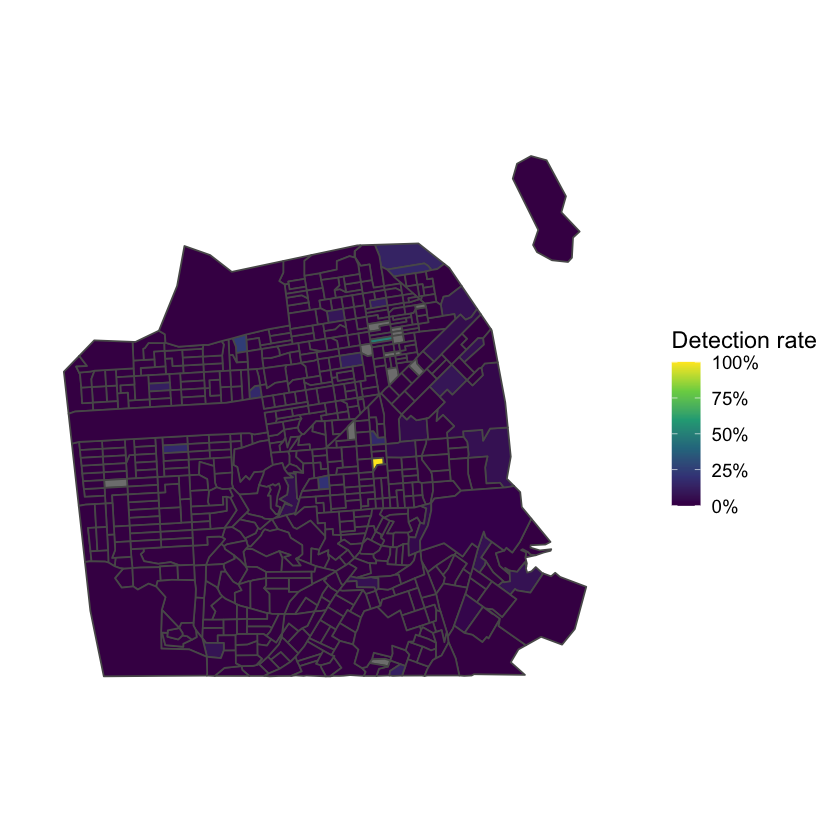

In [55]:
# Appendix: Plot detection rate against minority share (SF only)
# NB: 
# - Plotting rates for each census block group instead of for each image.
# - These plots don't look great due to the low number of points.
df_sf <- st_join(
    census_sf %>%
      mutate(percentage_minority = (total_pop - total_white) / total_pop),
    cameras_sf %>%
      st_as_sf(coords = c("lon", "lat"),
               crs = 4269, # ensure same coords as tidycensus
               agr = "constant")
  ) %>%
  group_by(GEOID) %>%
  summarize(percentage_minority = first(percentage_minority),
            detection_rate = sum(verified) / n()) %>% 
  suppressMessages()

df_sf %>%
  ggplot(aes(x = percentage_minority, y = detection_rate)) +
  # Different modelling options: 
  #geom_point() +
  geom_smooth() +
  # geom_smooth(method = "lm",
  #             formula = y ~ poly(x, degree = 2),
  #             se = T) +
  scale_x_continuous(
    name = "Minority share of population (census block group)", 
    expand = expansion(mult = c(0, 0.05)),
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_y_continuous(
    name = "Identification rate",  
    limits = c(0, NA),
    oob = scales::squish,
    expand = expansion(mult = c(0, 0.1)),
    labels = scales::percent_format(accuracy = 0.1)
  ) +
  theme(
    panel.grid = element_blank(),
    panel.border = element_blank(),
    axis.text = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.title = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.line = element_line(size = 0.5, color = "black"),
    axis.ticks.x = element_line(size = 0.5, color = "black"),
    axis.ticks.y = element_line(size = 0.5, color = "black")
  ) 

ggplot(df_sf, aes(fill = detection_rate)) +
  geom_sf() +
  scale_x_continuous(limits = c(-122.52, -122.35)) +
  scale_y_continuous(limits = c(37.7, 37.84)) +
  scale_fill_viridis_c("Detection rate", labels = scales::percent) +
  theme(axis.text = element_blank(), 
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank())